In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime

import scipy.stats as ss

In [2]:
pd.read_parquet("../../data/website/databricks/hourly2/aug2019.parquet").drop_duplicates()

,timestamp,domain,trafficType,accessType,y,x
0,1566896400,ru.wikipedia,spider,desktop,4,40
1,1566889200,ru.wikipedia,spider,mobile-web,1,3241
2,1566882000,en.wikipedia,spider,desktop,10,61
3,1566871200,en.wikipedia,spider,desktop,14,14
4,1566864000,en.wikipedia,user,desktop,3,330
...,...,...,...,...,...,...
463375,1567274400,es.wikipedia,user,mobile-web,37,1
463376,1567260000,es.wikipedia,user,mobile-web,5108,1
463377,1567252800,es.wikipedia,user,desktop,8,1
463378,1567252800,de.wikipedia,user,mobile-app,76,1


In [3]:
df = pd.concat([
    pd.read_parquet("../../data/website/databricks/hourly2/aug2019.parquet").drop_duplicates(),
    pd.read_parquet("../../data/website/databricks/hourly2/sep2019.parquet").drop_duplicates(),
    pd.read_parquet("../../data/website/databricks/hourly2/oct2019.parquet").drop_duplicates(),
], axis=0, ignore_index=True)

df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df

,timestamp,domain,trafficType,accessType,y,x,date
0,1566896400,ru.wikipedia,spider,desktop,4,40,2019-08-27 09:00:00
1,1566889200,ru.wikipedia,spider,mobile-web,1,3241,2019-08-27 07:00:00
2,1566882000,en.wikipedia,spider,desktop,10,61,2019-08-27 05:00:00
3,1566871200,en.wikipedia,spider,desktop,14,14,2019-08-27 02:00:00
4,1566864000,en.wikipedia,user,desktop,3,330,2019-08-27 00:00:00
...,...,...,...,...,...,...,...
1099125,1570154400,ru.wikipedia,user,mobile-web,9,1,2019-10-04 02:00:00
1099126,1570179600,en.wikipedia,user,desktop,36,4,2019-10-04 09:00:00
1099127,1570136400,de.wikipedia,user,mobile-app,562,1,2019-10-03 21:00:00
1099128,1570140000,en.wikipedia,user,mobile-web,13596,1,2019-10-03 22:00:00


In [4]:
def bucketmaker(df, buckets):

    binstarts = buckets
    binends = np.roll(binstarts, -1)
    binends[-1] = np.inf
    occurences = np.zeros_like(binstarts)

    for _, (x, y) in df[["x", "y"]].iterrows():
        for i, (start, end) in enumerate(zip(binstarts, binends)):
            if (y >= start) and (y < end):
                occurences[i] += x

    probabilities = occurences / np.sum(occurences)

    return probabilities

In [5]:
def bucketmaker_np(df, buckets):
    dist = []

    for _, (x, y) in df[["x", "y"]].iterrows():
        dist += [y] * x

    logdist = np.log10(dist)

    hist = np.histogram(logdist, bins=len(buckets), range=(np.log10(min(buckets)), np.log10(max(buckets))), density=False)

    occurences, bins = hist
    probability = occurences/np.sum(occurences)

    return probability

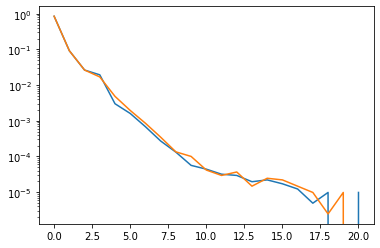

In [6]:
smalldf = df[df["timestamp"] == 1566896400]

plt.plot(bucketmaker(smalldf, np.logspace(0,4,21)))
plt.plot(bucketmaker_np(smalldf, np.logspace(0,4,21)))
plt.yscale("log")
plt.show()

# print(np.allclose(bucketmaker(smalldf), bucketmaker_np(smalldf)))

# %timeit bucketmaker(smalldf)
# %timeit bucketmaker_np(smalldf)
# plt.yscale("log")

The buckets below are not perfect, they dont really match the dist

maybe lets use the custom buckets:

idea 1: 1,2,3,4,5,6,7,8,9, 10,20,30, ..., 100, 200, 300, .., 1000, 2000, 3000, ...

or lets use something like:

[1 or higher ] [2 or higher] [3 or higher], [3 or higher], ... [1000 or higher]

so a dist like
1,1,1,1,1000000 gets a higher weight than 1,1,1,1,100
even though with above buckets they would not get

In [7]:
buckets = np.logspace(0,5,21)

probdf = df.groupby(["domain", "date"]).apply(bucketmaker, buckets).reset_index()
probdf[[f"self_{i:.3f}" for i in buckets]] = probdf.apply(lambda row: row[0], axis=1, result_type="expand")
probdf.drop(columns=0, inplace=True)
probdf

,domain,date,self_1.000,self_1.778,self_3.162,self_5.623,self_10.000,self_17.783,self_31.623,self_56.234,...,self_562.341,self_1000.000,self_1778.279,self_3162.278,self_5623.413,self_10000.000,self_17782.794,self_31622.777,self_56234.133,self_100000.000
0,de.wikipedia,2019-08-01 00:00:00,0.838345,0.144581,0.010007,0.004539,0.001135,0.000413,0.000413,0.000155,...,0.000052,0.000000,0.000000,0.000052,0.000052,0.0,0.0,0.0,0.0,0.0
1,de.wikipedia,2019-08-01 01:00:00,0.868595,0.114275,0.011195,0.003156,0.001427,0.000376,0.000376,0.000075,...,0.000000,0.000000,0.000000,0.000075,0.000000,0.0,0.0,0.0,0.0,0.0
2,de.wikipedia,2019-08-01 02:00:00,0.885971,0.094074,0.011576,0.005010,0.001469,0.000864,0.000346,0.000086,...,0.000000,0.000000,0.000000,0.000086,0.000000,0.0,0.0,0.0,0.0,0.0
3,de.wikipedia,2019-08-01 03:00:00,0.875372,0.107582,0.009166,0.004020,0.001367,0.000965,0.000804,0.000161,...,0.000161,0.000000,0.000080,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,de.wikipedia,2019-08-01 04:00:00,0.838555,0.136675,0.014932,0.004802,0.002401,0.000995,0.000703,0.000293,...,0.000000,0.000117,0.000000,0.000059,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,zh.wikipedia,2019-10-12 19:00:00,0.904214,0.074980,0.013609,0.005103,0.000523,0.000262,0.000393,0.000000,...,0.000000,0.000000,0.000000,0.000131,0.000000,0.0,0.0,0.0,0.0,0.0
10508,zh.wikipedia,2019-10-12 20:00:00,0.936463,0.050258,0.008128,0.003434,0.000458,0.000343,0.000000,0.000229,...,0.000000,0.000114,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
10509,zh.wikipedia,2019-10-12 21:00:00,0.943494,0.043052,0.006458,0.004413,0.001076,0.000538,0.000108,0.000108,...,0.000108,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
10510,zh.wikipedia,2019-10-12 22:00:00,0.927760,0.054469,0.010200,0.005363,0.001052,0.000105,0.000210,0.000210,...,0.000105,0.000000,0.000105,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [8]:
# KULLBACK-LEIBLER DIVERGENCE -- CHECKED
def KLD_dis(x, y, logbase=2):
    """Discrete kullback-Leibler divergence D(P(x)||Q(x)) for X, Y values stored in
    two arrays:
    - NOTE: there should be no events in x array that do not occur in y array
    - x: array with samples
    - y: array with samples
    - logbase: the base for the shannon entropy units
    """
    assert len(x) == len(y), "Arrays x and y have mismatching dimensions."

    # determining P(x)
    unique_x, count_x = np.unique(x, return_counts = True, axis=0)
    p_x = count_x / len(x)
    p_x = p_x[p_x > 0]

    # calculating the occurence of x in events in array y - Q(x)
    count_y = np.zeros((len(unique_x)))
    for i, x_val in enumerate(unique_x): # not the most efficient way, maybe there is a smarter way to 
        count_y[i] = np.count_nonzero(y == x_val)

    q_x = count_y/ len(y)
    q_x = q_x[q_x > 0]

    assert len(q_x) == len(p_x), "P(x) and Q(x) have mismatching dimensions."

    kl = np.sum(p_x * (np.log(p_x/q_x) / np.log(logbase)))
    return kl

In [9]:
def chisquared_distance(A, B):
    summ = 0
    for a,b in zip(A, B):
        if (a + b) == 0:
            continue
        val = ((a - b) ** 2) / (a + b)
        if val == np.nan:
            continue
        summ += val
    chi = 0.5 * summ
    return chi

In [10]:
# att_df = grouped_df[ ((grouped_df.date.dt.year == 2019) & (grouped_df.date.dt.month == 9) & (grouped_df.date.dt.day == 6))]
# ref_df = grouped_df[~((grouped_df.date.dt.year == 2019) & (grouped_df.date.dt.month == 9) & (grouped_df.date.dt.day == 6))]

# print(att_df.shape)
# print(ref_df.shape)

# # for attack we only have 1 day, so mean() does not do anything, however we still need to give a 'dummy' function to 
# # transform the groupby into a dataframe
# att_df = att_df.groupby(["domain", att_df.date.dt.hour]).mean().reset_index().rename(columns={"date":"hour"})
# # for reference, group by all 24 hours, then take mean probability across all 50 or so days
# ref_df = ref_df.groupby(["domain", ref_df.date.dt.hour]).mean().reset_index().rename(columns={"date":"hour"})

# print(att_df.shape)
# print(ref_df.shape)

In [11]:
probdf[[f"ref_{i:.3f}" for i in buckets]] = np.nan
self_buckets = [i for i in probdf.columns if "self" in i]
ref_buckets = [i for i in probdf.columns if "ref" in i]

In [12]:
for idx, (_, date, *_) in probdf.iterrows():
    if idx%1000 == 0: print(idx, end="")
    probdf.loc[idx, ref_buckets] = probdf.loc[
        (
            # exclude attack i.e. include any day where at least of of the statements below is False, and for
            # attack day they are all true
            ((probdf.date.dt.year != 2019) | (probdf.date.dt.month != 9) | (probdf.date.dt.day != 6)) &
            # exclude day after attack
            ((probdf.date.dt.year != 2019) | (probdf.date.dt.month != 9) | (probdf.date.dt.day != 7)) &
            # exlude same day
            (probdf.date != date) &
            # exclude 
            (probdf.date.dt.hour == date.hour)
        ), self_buckets
    ].mean(axis=0).to_numpy()  # to_numpy to get rid of the self_buckets columns

010002000300040005000600070008000900010000

In [13]:
metric_df = probdf[["domain", "date"]]
metric_df["self_entropy"] = np.nan
metric_df["ref_entropy"] = np.nan
metric_df["kl"] = np.nan
metric_df["chi"] = np.nan
# metric_df["size"] = np.nan

In [14]:
for idx, row in probdf.iterrows():
    if idx%1000 == 0: print(idx, end="")

    self_dist = row[self_buckets].to_numpy(dtype="float64")
    ref_dist = row[ref_buckets].to_numpy(dtype="float64")

    metric_df.loc[idx, "self_entropy"] = ss.entropy(self_dist, base=2)
    metric_df.loc[idx, "ref_entropy"] = ss.entropy(ref_dist, base=2)
    metric_df.loc[idx, "chi"] = chisquared_distance(self_dist, ref_dist)
    metric_df.loc[idx, "kl"] = ss.entropy(self_dist, ref_dist, base=2)

010002000300040005000600070008000900010000

In [15]:
# metric_df.to_csv("../../data/small/quantitative/metric1.csv")
metric_df

,domain,date,self_entropy,ref_entropy,kl,chi
0,de.wikipedia,2019-08-01 00:00:00,0.746463,0.669561,0.006453,0.002154
1,de.wikipedia,2019-08-01 01:00:00,0.662689,0.656375,0.000634,0.000207
2,de.wikipedia,2019-08-01 02:00:00,0.623693,0.663326,0.003928,0.001350
3,de.wikipedia,2019-08-01 03:00:00,0.648480,0.669061,0.002219,0.000682
4,de.wikipedia,2019-08-01 04:00:00,0.782746,0.680727,0.005070,0.001624
...,...,...,...,...,...,...
10507,zh.wikipedia,2019-10-12 19:00:00,0.558996,0.849296,0.042396,0.015633
10508,zh.wikipedia,2019-10-12 20:00:00,0.410409,0.844834,0.083512,0.031474
10509,zh.wikipedia,2019-10-12 21:00:00,0.384539,0.810215,0.087232,0.033056
10510,zh.wikipedia,2019-10-12 22:00:00,0.461739,0.750945,0.049764,0.018673


In [16]:
ref_days_df = metric_df.loc[(
    ((metric_df.date.dt.year != 2019) | (metric_df.date.dt.month != 9) | (metric_df.date.dt.day != 6)) &
    ((metric_df.date.dt.year != 2019) | (metric_df.date.dt.month != 9) | (metric_df.date.dt.day != 7)))]

attack_day_df = metric_df.loc[(metric_df.date.dt.year == 2019) & (metric_df.date.dt.month == 9) & (metric_df.date.dt.day == 6)]

ref_days_df = ref_days_df.replace([np.inf, -np.inf], np.nan).dropna()  # todo: remove NAN at prior step

attack_day_grouped = attack_day_df.groupby(["domain", attack_day_df.date.dt.hour]).mean().reset_index()
attack_day_grouped.rename(columns={"date":"hour"}, inplace=True)
ref_days_grouped_mean = ref_days_df.groupby(["domain", ref_days_df.date.dt.hour]).mean().reset_index()
ref_days_grouped_std = ref_days_df.groupby(["domain", ref_days_df.date.dt.hour]).std().reset_index()
ref_days_grouped_mean.rename(columns={"date":"hour"}, inplace=True)
ref_days_grouped_std.rename(columns={"date":"hour"}, inplace=True)

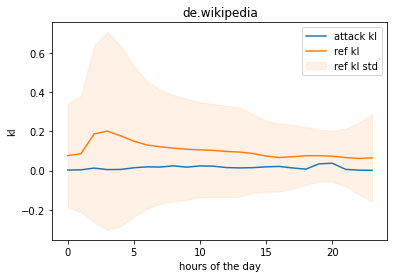

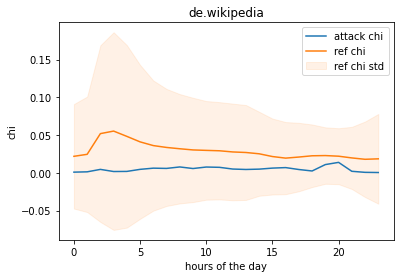

In [17]:
domain = "de.wikipedia"

x = attack_day_grouped[attack_day_grouped["domain"] == domain]["hour"]
attack_kl = attack_day_grouped[attack_day_grouped["domain"] == domain]["kl"]
attack_chi = attack_day_grouped[attack_day_grouped["domain"] == domain]["chi"]

ref_kl_mean = ref_days_grouped_mean[ref_days_grouped_mean["domain"] == domain]["kl"]
ref_kl_std = ref_days_grouped_std[ref_days_grouped_std["domain"] == domain]["kl"]

ref_chi_mean = ref_days_grouped_mean[ref_days_grouped_mean["domain"] == domain]["chi"]
ref_chi_std = ref_days_grouped_std[ref_days_grouped_std["domain"] == domain]["chi"]

plt.title(domain)
plt.plot(x, attack_kl, label="attack kl")
plt.plot(x, ref_kl_mean, label="ref kl")
plt.fill_between(x, ref_kl_mean-ref_kl_std, ref_kl_mean+ref_kl_std, label="ref kl std", alpha=0.1, color="C1")
plt.legend()
plt.xlabel("hours of the day")
plt.ylabel("kl")
plt.show()

plt.title(domain)
plt.plot(x, attack_chi, label="attack chi")
plt.plot(x, ref_chi_mean, label="ref chi")
plt.fill_between(x, ref_chi_mean-ref_chi_std, ref_chi_mean+ref_chi_std, label="ref chi std", alpha=0.1, color="C1")
plt.legend()
plt.xlabel("hours of the day")
plt.ylabel("chi")
plt.show()

In [18]:
ref_days_df.replace([np.inf, -np.inf], np.nan, inplace=True)
ref_days_df.dropna(inplace=True)

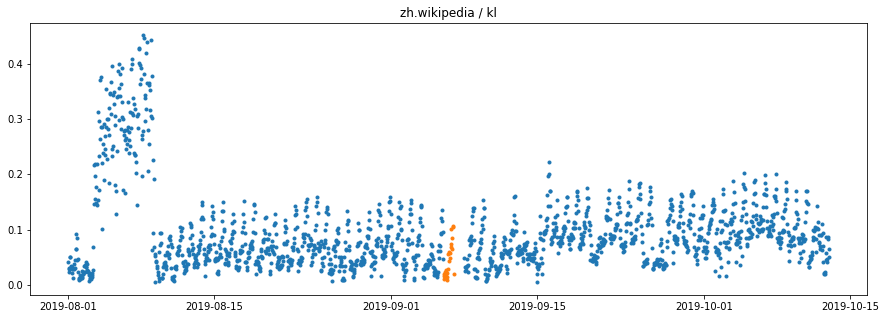

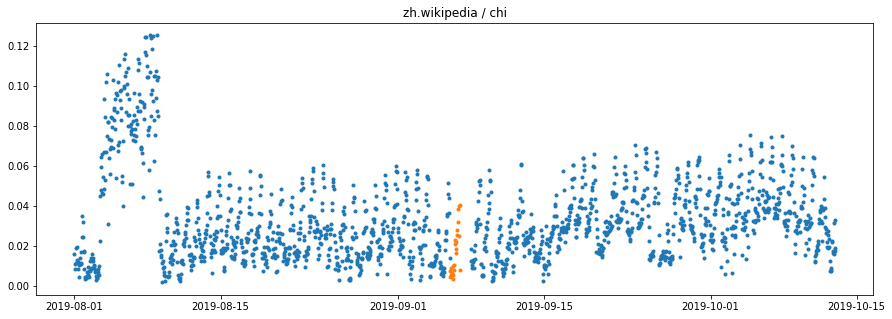

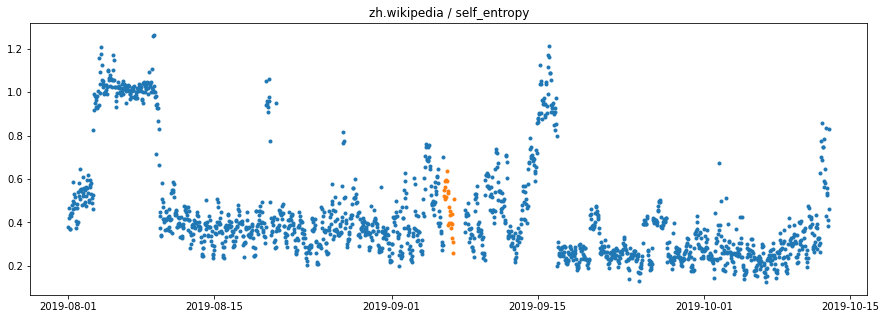

In [26]:
unique_domains = attack_day_df.domain.unique().flatten()
domain = unique_domains[5]

metric = "kl"
plt.figure(figsize=(15,5))
plt.title(domain + " / " + metric)
plt.plot(ref_days_df[ref_days_df["domain"]==domain]['date'], ref_days_df[ref_days_df["domain"]==domain][metric], ".", color="C0")
plt.plot(attack_day_df[attack_day_df["domain"]==domain]['date'], attack_day_df[attack_day_df["domain"]==domain][metric], ".", color="C1")
plt.show()

metric = "chi"
plt.figure(figsize=(15,5))
plt.title(domain + " / " + metric)
plt.plot(ref_days_df[ref_days_df["domain"]==domain]['date'], ref_days_df[ref_days_df["domain"]==domain][metric], ".", color="C0")
plt.plot(attack_day_df[attack_day_df["domain"]==domain]['date'], attack_day_df[attack_day_df["domain"]==domain][metric], ".", color="C1")
plt.show()

metric = "self_entropy"
plt.figure(figsize=(15,5))
plt.title(domain + " / " + metric)
plt.plot(ref_days_df[ref_days_df["domain"]==domain]['date'], ref_days_df[ref_days_df["domain"]==domain][metric], ".", color="C0")
plt.plot(attack_day_df[attack_day_df["domain"]==domain]['date'], attack_day_df[attack_day_df["domain"]==domain][metric], ".", color="C1")
plt.show()